In [1]:
from brian2 import *
import brian2.numpy_ as np
prefs.codegen.target = 'numpy'
import timeit

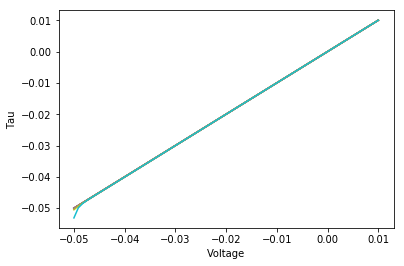

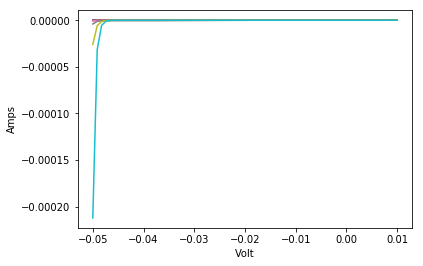

30.43223281018436


In [2]:
start = timeit.default_timer()

start_scope()
#Implementing the independent CaT current.

duration = 100*ms
#Parameters
C = 1*ufarad
V0 = -65*mV
temp = 34
gCaTmax = 0.001*siemens
Cai = 50 * nmole
Cao = 2 * mmole
q10 = 5
a0m = 0.04/ms
a0h = 0.015/ms
zetam = 2/mV
zetah = 3.5/mV
vhalfm = -28*mV
vhalfh = -75*mV
gmm = 0.1
gmh = 0.6
f = ((25/293.15)*(temp + 273.15))*mV/2
qt = q10 ** ((temp - 25) / 10)

@check_units(z=1, result=1)    
def efun(z):
    if (np.absolute(z) < 0.0001): 
        return 1 - z/2
    else:
        return z/(exp(z) - 1)
    
@check_units(V=volt, result=1)
def nu(V):
    return V / f


@check_units(V=volt, result=volt)
def ghk(V):
    return -f * (1 - (Cai / Cao) * exp(nu(V))) * efun(nu(V))


eqs = Equations('''
                    dV/dt = (ICaT + I)/C : volt
                    ICaT = gCaT*ghk(V) : amp (constant over dt)
                    gCaT = gCaTmax*mCaT*mCaT*hCaT : siemens
                    dmCaT/dt = (infmCaT - mCaT)/taum : 1
                    dhCaT/dt = (infhCaT - hCaT)/tauh : 1
                    infmCaT = alpm/(alpm+betm) : 1
                    infhCaT = alph/(alph+beth) : 1
                    alpm = 0.2*(mV**-1)*(-V+19.26*mV)/(exp((-V+19.26*mV)/(10.0*mV))-1) : 1
                    alph = 10**-6*exp(-V/(16.26*mV)) : 1
                    alpmt = exp(0.0378*zetam*(V-vhalfm)) : 1
                    betm = 0.009*exp(-V/(22.03*mV)) : 1
                    beth = 1/(exp((-V+29.79*mV)/(10*mV))+1) : 1
                    betmt = exp(0.0378*zetam*gmm*(V-vhalfm)) : 1
                    taum = betmt/(qt*a0m*(1+alpmt)) : second
                    tauh = beth/(a0h*(1+alph)) : second                    
                    I : amp               
                    ''')

group = NeuronGroup(1, eqs, threshold='V > -40*mV', refractory='V > -40*mV', method='rk2')

alpm0 = 0.2*(mV**-1)*(-V0+19.26*mV)/(exp((-V0+19.26*mV)/(10.0*mV))-1)
betm0 = 0.009*exp(-V0/(22.03*mV))
alph0 = 10**-6*exp(-V0/(16.26*mV))
beth0 = 1/(exp((-V0+29.79*mV)/(10*mV))+1)
group.mCaT = alpm0/(alpm0+betm0)
group.hCaT = alph0/(alph0+beth0)

M = StateMonitor(group, variables=True, record=True)

store()
# Plot tau and the channel current for different voltages
voltages = np.linspace(-50, 10, 70) * mV
vs = []
Is = []
for volt in voltages:
    # Restore the original state of the network
    restore()
    group.V = volt
    alpm0 = 0.2*(mV**-1)*(-volt+19.26*mV)/(exp((-volt+19.26*mV)/(10.0*mV))-1)
    betm0 = 0.009*exp(-volt/(22.03*mV))
    alph0 = 10**-6*exp(-volt/(16.26*mV))
    beth0 = 1/(exp((-volt+29.79*mV)/(10*mV))+1)
    group.mCaT = alpm0/(alpm0+betm0)
    group.hCaT = alph0/(alph0+beth0)
    # Run it with the new value of tau
    run(1 * ms)
    vs.append(M.V[0])
    Is.append(M.ICaT[0])

figure(1)
plot(voltages, vs)
xlabel('Voltage')
ylabel('Tau');

figure(2)
plot(voltages, Is)
xlabel('Volt')
ylabel('Amps');
show()

stop = timeit.default_timer()
print(stop - start)

0.00343880547556
1.05806149664
1.00363846767


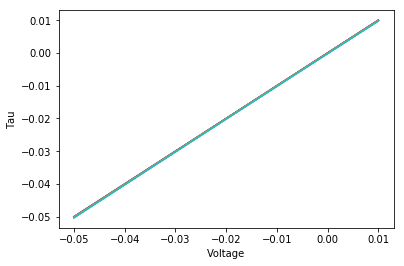

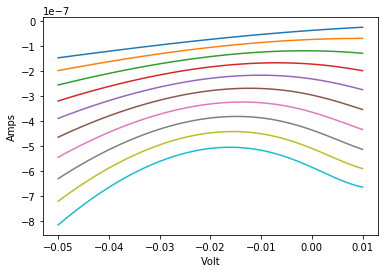

In [3]:
start_scope()
#Implementing the independent CaN current.

duration = 100*ms
#Parameters
C = 1*ufarad
gCaNmax = 0.001*siemens
Cai = 50 * nmole
Cao = 2 * mmole
q10 = 5
a0m = 0.03/ms
zetam = 2/mV
vhalfm = -14*mV
gmm = 0.1
temp = 34
f = ((25/293.15)*(temp + 273.15))*mV/2
V0 = -65*mV
ki = 1*nmole
h2 = ki/(ki+Cai)
qt = q10 ** ((temp - 25) / 10)

@check_units(z=1, result=1)    
def efun(z):
    if (np.absolute(z) < 0.0001): 
        return 1 - z/2
    else:
        return z/(exp(z) - 1)
    
@check_units(V=volt, result=1)
def nu(V):
    return V / f


@check_units(V=volt, result=volt)
def ghk(V):
    return -f * (1 - (Cai / Cao) * exp(nu(V))) * efun(nu(V))

eqs = Equations('''
                    dV/dt = (ICaN + I)/C : volt
                    ICaN = gCaN*ghk(V) : amp (constant over dt)
                    gCaN = gCaNmax*mCaN*mCaN*hCaN*h2 : siemens
                    dmCaN/dt = (infmCaN - mCaN)/taum : 1
                    dhCaN/dt = (infhCaN - hCaN)/tauh : 1
                    infmCaN = alpm*(1/alpm+betm) : 1
                    infhCaN = alph*(1/alph+beth) : 1
                    taum = betmt/(qt*a0m*(1+alpmt)) : second
                    tauh = (1*ms/(alph+beth))/qt : second
                    alpm = 0.1967*(mV**-1)*(-V+19.88*mV)/(exp((-V+19.88*mV)/(10.0*mV))-1) : 1
                    alph = 0.00016*exp(-V/(48.4*mV)) : 1
                    alpmt = exp(0.0378*zetam*(V-vhalfm)) : 1 
                    betm = 0.046*exp(-V/(20.73*mV)) : 1
                    beth = 1/(exp((-V+39*mV)/(10*mV))+1.) : 1
                    betmt = exp(0.0378*zetam*gmm*(V-vhalfm)) : 1
                    I : amp
                    ''')

group = NeuronGroup(1, eqs, threshold='V > -40*mV', refractory='V > -40*mV', method='rk2')

alpm0 = 0.1967*(mV**-1)*(-V0+19.88*mV)/(exp((-V0+19.88*mV)/(10*mV))-1)
betm0 = 0.046*exp(65/20.73)
group.mCaN = alpm0*(1/alpm0+betm0)
group.hCaN = 0.00016*exp(-V0/(48.4*mV))*(1/0.00016*exp(-V0/(48.4*mV))+1/(exp((-V0+39*mV)/(10*mV))+1))

M = StateMonitor(group, variables=True, record=True)

store()
# Plot tau and the channel current for different voltages
voltages = np.linspace(-50, 10, 70) * mV
vs = []
Is = []
for volt in voltages:
    # Restore the original state of the network
    restore()
    group.V = volt
    alpm0 = 0.1967*(mV**-1)*(-volt+19.88*mV)/(exp((-volt+19.88*mV)/(10*mV))-1)
    betm0 = 0.046*exp(65/20.73)
    group.mCaN = alpm0*(1/alpm0+betm0)
    group.hCaN = 0.00016*exp(-volt/(48.4*mV))*(1/0.00016*exp(-volt/(48.4*mV))+1/(exp((-volt+39*mV)/(10*mV))+1))
    # Run it with the new value of tau
    run(1 * ms)
    vs.append(M.V[0])
    Is.append(M.ICaN[0])

figure(1)
plot(voltages, vs)
xlabel('Voltage')
ylabel('Tau');

figure(2)
plot(voltages, Is)
xlabel('Volt')
ylabel('Amps');
show()

0.000997807116171
115.28331173


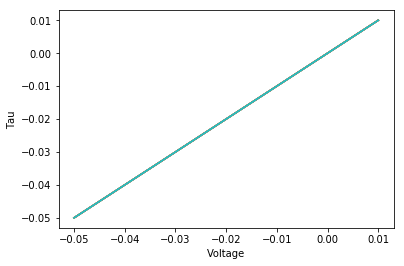

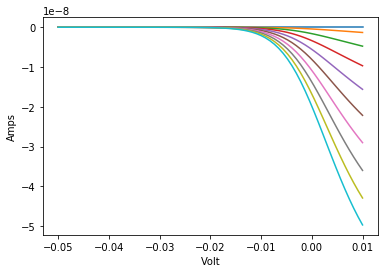

In [2]:
start_scope()
# Implementing the independent CaL current.

duration = 100* ms
# Parameters
C = 1 * ufarad
gCaLmax = 0.001 * siemens
Cai = 50 * nmole
Cao = 2 * mmole
temp = 34
KTF = ((25 / 293.15) * (temp + 273.15))
f = KTF * mV / 2
ki = 1 * nmole
h2 = ki / (ki + Cai)
q10 = 5
qt = q10 ** ((temp - 25) / 10)
a0m = 0.1
zetam = 2/mV
vhalfm = 4*mV
gmm = 0.1
V0 = -65 * mV

@check_units(z=1, result=1)
def efun(z):
    if (np.absolute(z) < 0.0001):
        return 1 - z / 2
    else:
        return z / (exp(z) - 1)


@check_units(V=volt, result=1)
def nu(V):
    return V / f


@check_units(V=volt, result=volt)
def ghk(V):
    return -f * (1 - (Cai / Cao) * exp(nu(V))) * efun(nu(V))

eqs = Equations('''
                    dV/dt = (ICaL + I)/C : volt
                    #ICaL = gCaLmax*mCaL*mCaL*h2*ghk(V) : amp (constant over dt)
                    ICaL = gCaL*ghk(V) : amp (constant over dt)
                    gCaL = gCaLmax*mCaL*mCaL*h2 : siemens
                    dmCaL/dt = (infmCaL - mCaL)/tau : 1
                    infmCaL = alp * 1/(alp + bet) : 1
                    alp = 15.69*(mV**-1)*(-V+81.5*mV)/(exp((-V+81.5*mV)/(10*mV))-1) : 1
                    bet = 0.29 * exp(-V/(10.86*mV)) : 1
                    tau = betmt*ms/(qt*a0m*(1+alpmt)) : second 
                    alpmt = exp(0.0378*zetam*(V-vhalfm)) : 1
                    betmt = exp(0.0378*zetam*gmm*(V-vhalfm)) : 1
                    I : amp                    
                    ''')


group = NeuronGroup(1, eqs, threshold='V > -40*mV', refractory='V > -40*mV', method='rk2')


alp0 = 15.69*(mV**-1)*(-V0+81.5*mV)/(exp((-V0+81.5*mV)/(10*mV))-1)
bet0 = 0.29 * exp(-V0/(10.86*mV))
print(alp0)
print(bet0)
group.mCaL = alp0 * 1/(alp0 + bet0)

M = StateMonitor(group, variables=True, record=True)

#run(1*ms)

store()
# Plot tau and the channel current for different voltages
voltages = np.linspace(-50, 10, 70) * mV
vs = []
Is = []
for volt in voltages:
    # Restore the original state of the network
    restore()
    group.V = volt
    # Run it with the new value of tau
    run(1 * ms)
    vs.append(M.V[0])
    Is.append(M.ICaL[0])

figure(1)
plot(voltages, vs)
xlabel('Voltage')
ylabel('Tau');

figure(2)
plot(voltages, Is)
xlabel('Volt')
ylabel('Amps');
show()

WARNING    /usr/lib/python3.6/site-packages/brian2/units/fundamentalunits.py:206: RuntimeWarning: overflow encountered in exp
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]
WARNING    /usr/lib/python3.6/site-packages/brian2/units/fundamentalunits.py:1371: RuntimeWarning: divide by zero encountered in true_divide
  result = operation(self_arr, other_arr)
 [py.warnings]
WARNING    <string>:13: RuntimeWarning: divide by zero encountered in true_divide
 [py.warnings]
WARNING    <string>:13: RuntimeWarning: divide by zero encountered in true_divide
 [py.warnings]
WARNING    <string>:13: RuntimeWarning: divide by zero encountered in true_divide
 [py.warnings]
WARNING    <string>:13: RuntimeWarning: divide by zero encountered in true_divide
 [py.warnings]
WARNING    <string>:13: RuntimeWarning: divide by zero encountered in true_divide
 [py.warnings]
WARNING    <string>:13: RuntimeWarning: divide by zero encountered in true_divide
 [py.warnings]
WARNING    <string>:13: R

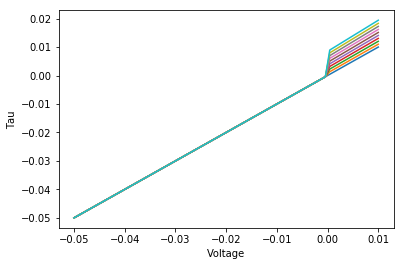

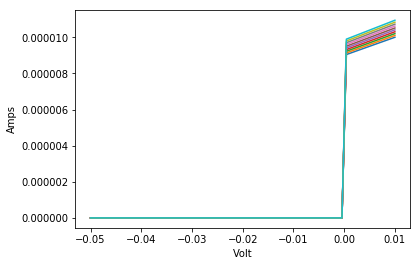

In [2]:
start_scope()
#Implementing the independent CaK current.

duration = 100*ms
#Parameters
C = 1*ufarad
Cai = 50*nmole
gCaKmax = 0.0001*siemens
temp = 34
VK = -90*mV
d1 = 0.84
d2 = 1
kalp = 480*nmole
kbet = 130*pmole
abar = 0.28/ms
bbar = 0.48/ms
R = 8.314*joule/mole
far = 96485*amp*second/mole
V0 = -40*mV

@check_units(k=mole, d=1,V=volt, result=mole)
def exp1(k, d, V):
    return k*exp(-2*d*far*V*(273.15 + temp)/R)

eqs = Equations('''
                    dV/dt = (ICaK + I)/C : volt
                    ICaK = gCaK*(V - VK) : amp            
                    gCaK = gCaKmax*oCaK : siemens
                    doCaK/dt = (infoCaK - oCaK)/tau : 1
                    infoCaK = alp*tau : 1
                    tau = 1/(alp + bet) : second  
                    alp = Cai*abar/(Cai + exp1(kalp, d1, V)) : Hz (constant over dt)
                    bet = bbar/(1 + Cai/exp1(kbet, d2, V)) : Hz (constant over dt)
                    I : amp
                    ''')

group = NeuronGroup(1, eqs, threshold='V > -40*mV', refractory='V > -40*mV', method='rk2')

alp0 = Cai*abar/(Cai + exp1(kalp, d1, V0)) 
bet0 = bbar/(1 + Cai/exp1(kbet, d2, V0))
tau = 1/(alp0 + bet0)
group.oCaK = alp0*tau

M = StateMonitor(group, variables=True, record=True)

#run(1*ms)

store()
# Plot tau and the channel current for different voltages
voltages = np.linspace(-50, 10, 70) * mV
vs = []
Is = []
for volt in voltages:
    # Restore the original state of the network
    restore()
    alp0 = Cai*abar/(Cai + exp1(kalp, d1, volt)) 
    bet0 = bbar/(1 + Cai/exp1(kbet, d2, volt))
    tau = 1/(alp0 + bet0)
    group.oCaK = alp0*tau
    group.V = volt
    # Run it with the new value of tau
    run(1 * ms)
    vs.append(M.V[0])
    Is.append(M.ICaK[0])

figure(1)
plot(voltages, vs)
xlabel('Voltage')
ylabel('Tau');

figure(2)
plot(voltages, Is)
xlabel('Volt')
ylabel('Amps');
show()

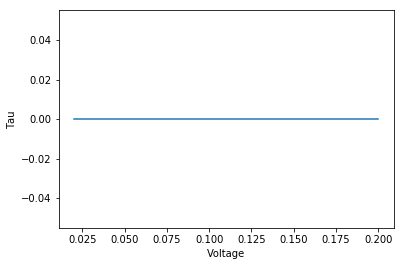

In [23]:
voltages = np.linspace(20, 200, 190)*mV
vs = []
for volt in voltages:
    vs.append(exp1(kalp, d1, volt))
    
figure(1)
plot(voltages, vs)
xlabel('Voltage')
ylabel('Tau');
show()
